In [1]:
from myAE import Manager
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F

/home/secondvoca/anaconda3/envs/torch/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
manager = Manager()
manager.prepare_data()

def calc_loss(model, x, y, F, device):
    h = model.get_submodule("encoder")(x)
    mu = h[:, :2]
    log_sigma = h[:, 2:4]
    sigma = log_sigma.exp()
    z = torch.rand_like(mu, device=device) * sigma + mu
    pred = model.get_submodule("decoder")(z)
    kl = 0.5*(mu.square() + sigma.square() - log_sigma - 1).sum(dim=1).mean()
    ll = F.binary_cross_entropy(pred, x, reduction='sum')/len(x)
    loss = ll + kl
    return loss

manager.set_default_model(4, 2)
hist = manager.train_on_cpu(calc_loss, epochs=30)

Now, it is working on cpu.


100%|██████████| 30/30 [05:41<00:00, 11.38s/it]


In [14]:
# get full latent data points
with torch.no_grad():
    latent_data_points = manager.model.get_submodule('encoder')(manager.training_data)[:, :2]

print(latent_data_points.shape)

torch.Size([60000, 2])


tensor([1.0457, 1.2108])
torch.Size([81, 1, 28, 28])
torch.Size([1, 1, 28, 28])


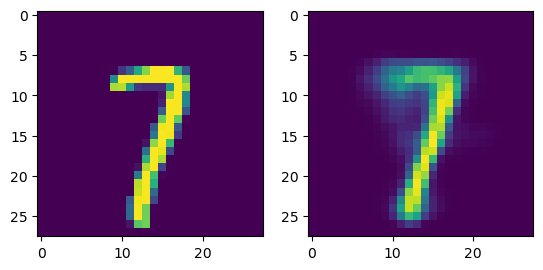

In [60]:
# generate a point in latent space
tmp_point = torch.randn(2)
print(tmp_point)

delta = 0.1

# select points close to the point
bool_indices = (
    (latent_data_points[:, 0] < tmp_point[0] + delta)
    & (latent_data_points[:, 0] > tmp_point[0] - delta)
    & (latent_data_points[:, 1] < tmp_point[1] + delta)
    & (latent_data_points[:, 1] > tmp_point[1] - delta)
)

near_data = manager.training_data[bool_indices]
print(near_data.shape)

# generate the image
with torch.no_grad():
    img = manager.model.get_submodule('decoder')(tmp_point.view(-1, 2))
print(img.shape)

# make copies of img
pred = torch.stack([img.view(1, 28, 28)] * len(near_data))

loss = F.mse_loss(pred, near_data, reduction='none')
loss = loss.sum(dim=[1, 2, 3])

# find index of least loss sample
min_idx = loss.argmin()
selected_data = near_data[min_idx]

_, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(selected_data.view(28, 28))
ax2.imshow(img.view(28, 28))
plt.show()

In [91]:
# generate a point in latent space
tmp_point = torch.randn(6000, 2)

# generate the image
with torch.no_grad():
    imgs = manager.model.get_submodule('decoder')(tmp_point)

imgs.shape

torch.Size([6000, 1, 28, 28])

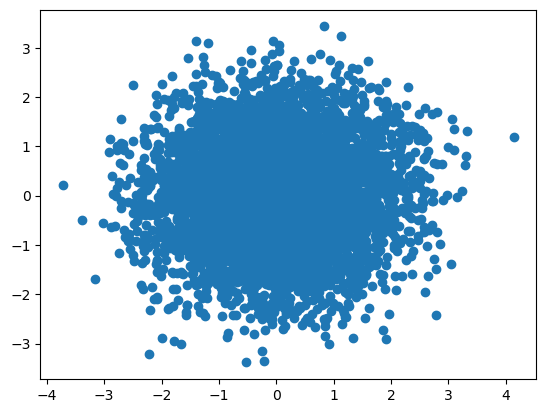

In [92]:
plt.scatter(tmp_point[:, 0], tmp_point[:, 1])
plt.show()

In [101]:
latent_data_points.shape

torch.Size([60000, 2])

In [104]:
new_data = []

from tqdm import tqdm

for pp, iimg in tqdm(zip(tmp_point, img)):
    delta = 0.1

    near_data = []

    while len(near_data) == 0:

        # select points close to the point
        bool_indices = (
            (latent_data_points[:, 0] < pp[0] + delta)
            & (latent_data_points[:, 0] > pp[0] - delta)
            & (latent_data_points[:, 1] < pp[1] + delta)
            & (latent_data_points[:, 1] > pp[1] - delta)
        )

        near_data = manager.training_data[bool_indices]

        delta += 0.1

    

    # make copies of img
    pred = torch.stack([iimg.view(1, 28, 28)] * len(near_data))

    loss = F.mse_loss(pred, near_data, reduction='none')
    loss = loss.sum(dim=[1, 2, 3])

    # find index of least loss sample
    min_idx = loss.argmin()
    selected_data = near_data[min_idx]

    new_data.append(selected_data)


0it [00:00, ?it/s]

6000it [00:04, 1457.52it/s]


In [105]:
new_data = torch.stack(new_data)
new_data.shape

torch.Size([6000, 1, 28, 28])

In [81]:
def show_100_images(imgs):
    tmp = torch.zeros(28 * 10, 28 * 10)
    
    for row in range(10):
        for col, img in enumerate(imgs[row * 10:(row + 1) * 10]):
            tmp[row * 28:(row + 1) * 28, col * 28: (col + 1) * 28] = img.view(28, 28)

    plt.figure(figsize=(20, 20))
    plt.imshow(tmp, cmap='gray')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [106]:
(new_data[2] == new_data[9]).all()

tensor(False)

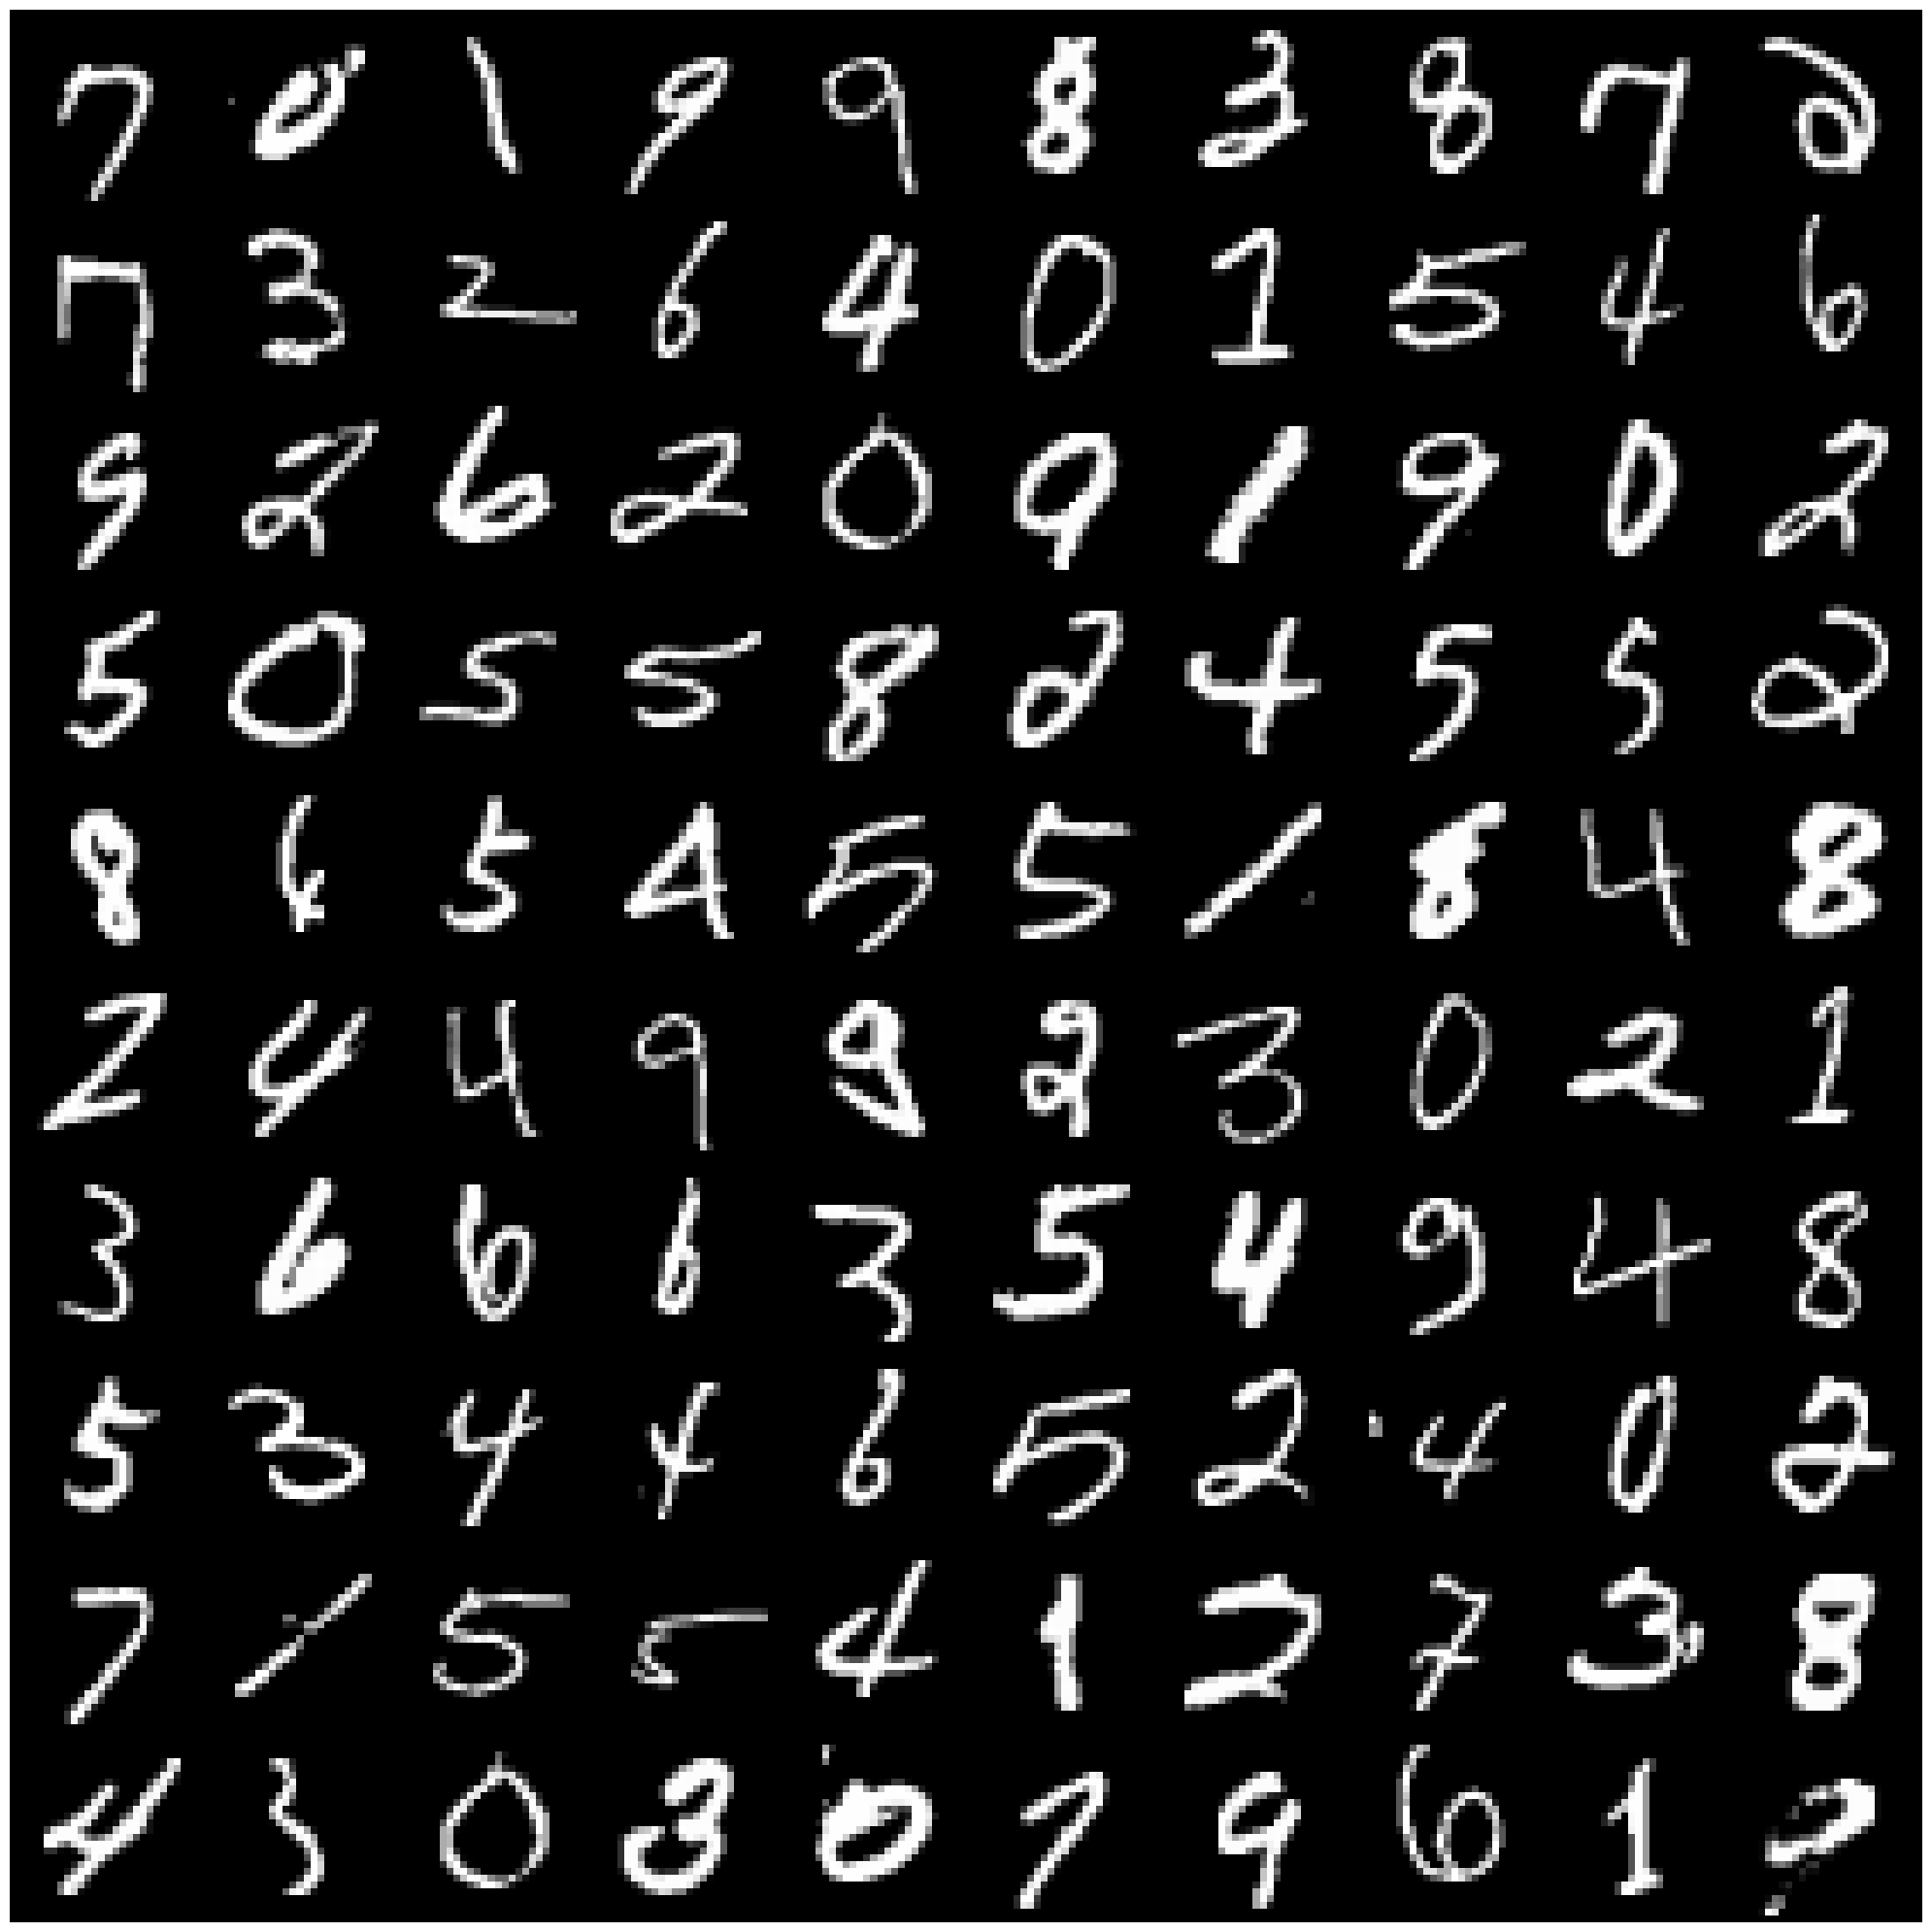

In [107]:
show_100_images(new_data[:100])

In [108]:
# set a new data loader
manager_2 = Manager()
manager_2.prepare_data()

from torch.utils.data import Dataset, DataLoader

class TmpDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

manager_2.training_data = new_data
manager_2.training_targets = torch.ones(6000)

manager_2.training_data_length = len(new_data)

manager_2.train_dataloader = DataLoader(
    TmpDataset(manager_2.training_data, manager_2.training_targets), batch_size=128, shuffle=True
)

manager_2.set_default_model(4, 2)

In [109]:
hist_2 = manager_2.train_on_cpu(calc_loss, epochs=30)

Now, it is working on cpu.


100%|██████████| 30/30 [00:22<00:00,  1.35it/s]


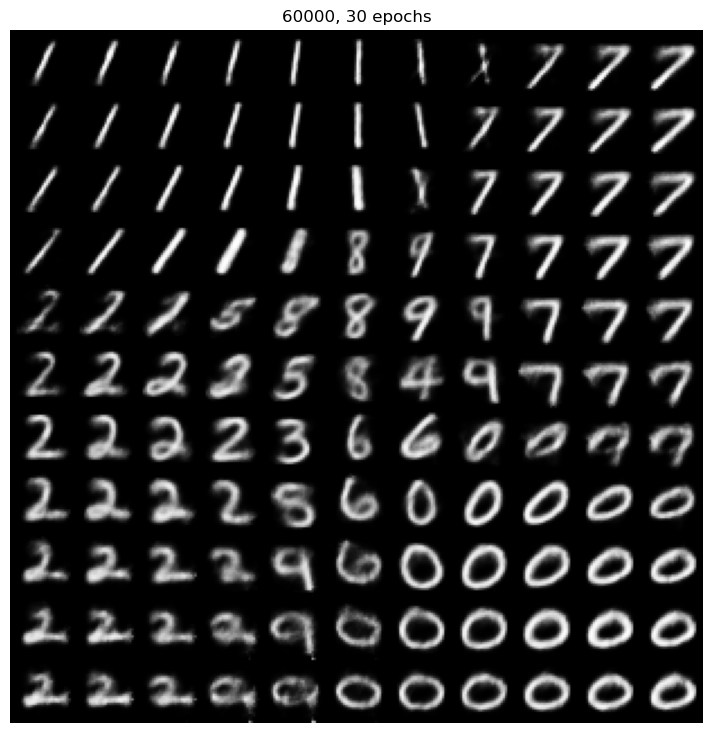

In [110]:
manager.plot_generated_images('60000, 30 epochs')

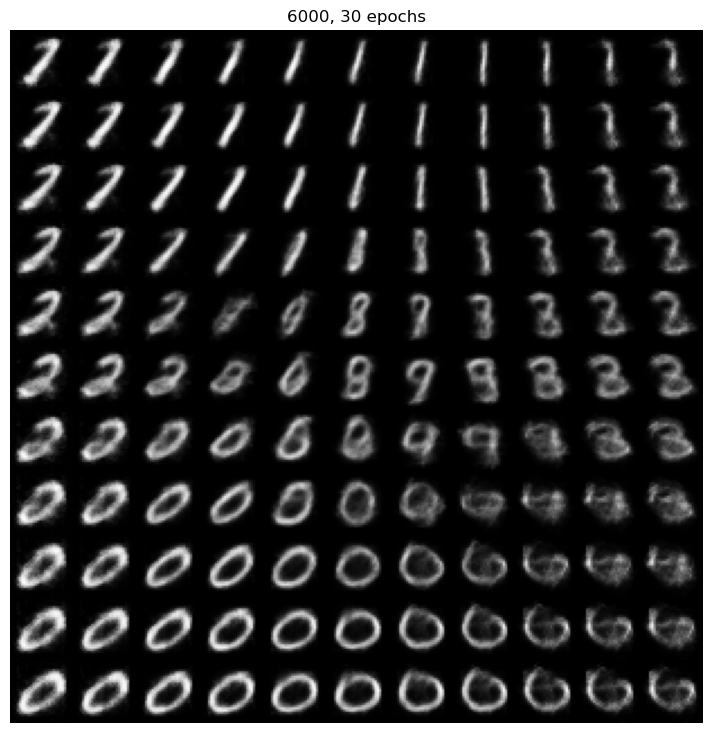

In [111]:
manager_2.plot_generated_images('6000, 30 epochs')